In [1]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from scipy import optimize
from writeit import rewritePipes

Populating the interactive namespace from numpy and matplotlib


In [2]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [3]:
efs3 = [(8.9381271260359245,7.630651190977825,6.7159547268865341,
6.9738486035512617, 7.9573769268773953, 9.0219969015283947),
       (8.8243783531405349,7.5344073470672601,6.5902105793246486,
8.9248285077595746, 9.3892931083845959, 9.6926128162354566),
       (8.7367567246589495,7.4103824075236799,6.6173529607348094,
7.5105239547305445, 8.443248306246991, 9.219006907136631),
       (9.0227632008125127,7.6926086616255906,6.7518615008119616,
7.0158885390239325, 8.024216900028474, 9.0069885818761133),
        (8.75512982,  7.44330083,  6.54405584,  7.05562264,  8.11023126,
        9.05479754)]
ef0s3 = [(9,8,7,7,8,9),(10,7,8,11,8.5,8.5),(9,5,7,11,10,9),(8,9,6,5,7,9),(8.5, 9, 7.5, 8, 9, 11)]
fi = [77074.919455,112655.831073,110580.174190,94608.944936,90337.059934]
ff = [76822.339443, 77378.352009,76951.906317,76844.979712,76820.739246757774]

In [4]:
case = 1

Mi = 10
Nt = 1
Nstar = 1
Np  =8
Nn = 9
L = 10
T = 24
a = 100
D = .1
Ltot = 48
Mr = 0.007
Qin = 0.0087
p0 = PyPipe_ps(10,D,Ltot,10,a)
h0 = p0.HofA(0.01*D*D*pi/4.,False)
if case ==1:
    Np =6
    Nn = Np+1
    oldinp = "../indata/DFDpleasework7.inp"
    e0,e1,e2,e3 =[7.5, 6.5, 7.5, 8.5]
    e0,e1,e2,e3 =[8.7409181741445288, 6.4482813556630605, 7.8603789169278508, 7.8071324922307346]
    elevs = [10,e0,e1,6,e2,e3,10]
    Nn = len(elevs)
    L = Ltot/float(Np)
    N = int(L)
    dx = L/float(N)
    M = max(int(T*a/(dx*.8))*5,1)
    dt = T/float(M)
    Ns = [N]*Np
    Ls = [L]*Np
    Mrs = [Mr]*Np  #manning roughness coeffs
    Ds = [D]*Np      #pipe diameter (m) 
    h0s = [h0]*Np    #IC for h
    q0s = [0]*Np    #IC for Q
    jt = [1]+[2]*(Nn-2)+[1]  #for DFDpleasework2.inp
    bt = [1]*Nn
    bv = [0]+[1]*(Nn-1)
    r =  [0]+[1]*(Nn-2)+[1]
    

fn = "../indata/DFD_crap"

(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
n1 = PyNetwork(fi,fc,1)
Q00 = Qin*np.ones(M+1)
n1.setbVal(0,Q00)


In [5]:
n1.runForwardProblem(dt)

In [6]:
print (sum([n1.getAveGradH(i) for i in range(M+1)]))

28572.1049899


Using Hermite modes
0.00393649870568


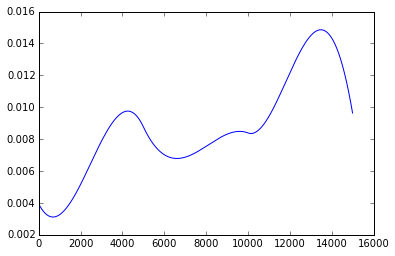

In [10]:
ndof = 7
x0 = np.zeros(ndof)
#x0[0] = q0s[0]
for k in range(ndof/2):
    x0[2*k+1]=Qin
wn =0
#x0 = np.array([-0.00020307339245325895, 0.008490629195457455, 0.0009253416251179748,0.009677741661820796, 0.0015352015270792105, 0.009917824124532194, -0.003963271068308179])
x0 =np.array([-0.001588089210705911, 0.008777164931212892, -0.0017525333453959123, 0.008388792963416304, -0.00032168574174775186, 0.009635039432584236, -0.004810498765067617])
Vin =Qin*T
opt1 = PyBC_opt_dh(fi, fc, ndof, x0, wn,Vin,0)
print "Using %s modes" %opt1.modetype
bval = opt1.getBCtimeseries()
plot(bval)
print bval[0]

In [9]:
opt1.compute_f()
f0 = opt1.f
print "f is %f" %opt1.f
print "T is %f" %opt1.T


f is 23897.403110
T is 24.000000


In [22]:
opt1.solve()

In [23]:
print elevs
print x0
print opt1.x
print "f_0 = %f, f_f = %f, f_f/f_0 = %f"%(f0,opt1.f,opt1.f/f0)

[10, 8.740918174144529, 6.4482813556630605, 6, 7.860378916927851, 7.807132492230735, 10]
[ 0.      0.0087  0.      0.0087  0.      0.0087  0.    ]
[-0.001588089210705911, 0.008777164931212892, -0.0017525333453959123, 0.008388792963416304, -0.00032168574174775186, 0.009635039432584236, -0.004810498765067617]
f_0 = 23897.403110, f_f = 2259.081636, f_f/f_0 = 0.094533


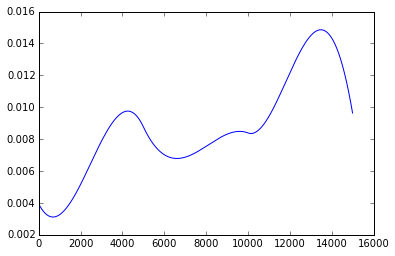

In [11]:
bval = opt1.getBCtimeseries()
plot(bval)

In [18]:
n1 = PyNetwork(fi,fc,1)

In [19]:
n1.setbVal(0,bval)
Ain = 0.0087*ones(M+1)
#A00 = 0.01*D*D*pi/4.*np.ones(Ns[0])
#Q00 = np.zeros(Ns[0])
#for k in range(0,Np):
#    n1.setIC(k,A00,Q00)
n1.setbVal(0,Ain)
dt = n1.T/float(n1.M)
V0 = n1.getTotalVolume()

In [20]:
n1.runForwardProblem(dt)

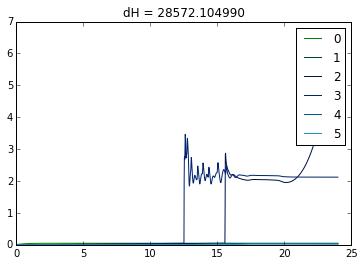

In [7]:
from matplotlib import cm
import matplotlib.colors as colors  
cNorm  = colors.Normalize(vmin=0, vmax=Np+1)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean'))
Mi = 10
m = 0
t = linspace(0,T,M/Mi)
Hs =np.ndarray((Np,M/Mi*Nt))
for j in range(Np):
    N = n1.Ns[j]
    p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
    qh = n1.qhist(j)
    Htemp = [p0.pbar(qh[idx_t(0,Nstar,n,n1.Ns[j])],False) for n in range(1,M+1,Mi)]
    Hs[j,m*(M/Mi):(M/Mi)*(m+1)] = Htemp
    plot(t,Hs[j,:], color = scalarMap.to_rgba(j), label = '%d'%j)
    title('dH = %f'%sum([n1.getAveGradH(i) for i in range(M+1)]))
legend()


In [17]:
print Vin
print V0
print sum(bval)*dt
print n1.getTotalVolume()-V0

0.2088
0.00376931188082
0.208810856543
0.214951855578


In [85]:
Q00 = x0[1]
print Q00*T

0.158603619276


In [8]:
print sum([n1.getAveGradH(i) for i in range(M+1)])

264489.325107


In [87]:
print sum([n1.getAveGradH(i) for i in range(M+1)])

79150.2155557


In [88]:
e0,e1,e2,e3,e4,e5,e6=(8.7981831100736905, 7.5383846965114314, 6.6122455959638113, 6.7449211689495092, 7.4885904774335481, 8.3439731634532635, 9.252878640650918)

In [89]:
elevs = [10,e0,e1,e2,6,e3,e4,e5,e6,10]

(0, 12)

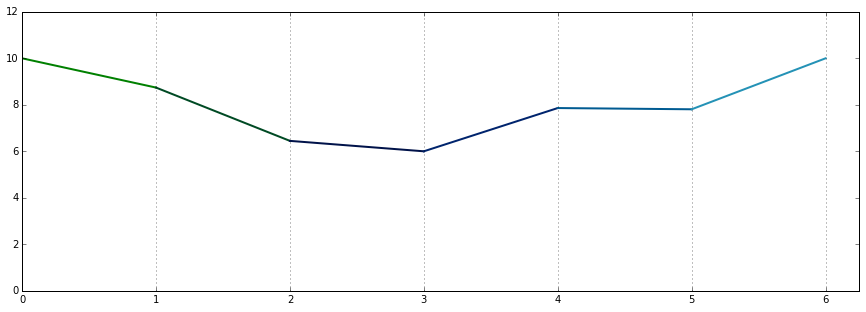

In [33]:
#Np = 9
#Nn =10
Ltot = 0
E = elevs[0]
xs = []


fig,ax = plt.subplots(nrows=1, figsize=(15,5))

for k in range(Nn-1):
    L = n1.Ls[0]
    x = linspace(0,L)
    cval = scalarMap.to_rgba(k)
    ax.plot(x+Ltot,x*(elevs[k+1]-elevs[k])/L+E,color = cval, lw = 2)
    xs.append(Ltot)
    Ltot+=L
    E = elevs[k+1]
xs.append(Ltot)
gca().set_xticks(xs);
gca().xaxis.grid(True)
gca().set_xticklabels(arange(0,Nn+1));
gca().set_ylim(0,12)

In [26]:
print opt1.x

[-0.0001066476701876127, 0.008652197074194894, -0.00014412284576527522, 0.0087011934889728, -0.0001255987679996523, 0.008664463809669733, 1.701696617699915e-05]


In [22]:
print h0

0.00328335033016
